In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import gc
gc.collect()
torch.cuda.empty_cache()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
import os
checkpoints = '/checkpoints'
if not os.path.exists(checkpoints):
    os.makedirs(checkpoints)

### ImageNet - can ignore

In [ ]:
def collate_fn(batch):
   batch = list(filter(lambda x: x is not None, batch))
   return torch.utils.data.dataloader.default_collate(batch) 

In [ ]:
def get_imagenet_data(augmentation=1): # imagenet = 224x224
  # Data augmentation transformations. Not for Testing!
  if augmentation:
    transform_train = transforms.Compose([
      transforms.Resize(256),
      transforms.CenterCrop(224),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor(),
    ])
  else: 
    transform_train = transforms.ToTensor()

  transform_test = transforms.Compose([
    transforms.ToTensor(),
  ])

  trainset = torchvision.datasets.ImageNet(root='/Users/hi/imagenet2012', split="train", transform=transform_train)
  # trainloader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True,
  #                                          collate_fn=collate_fn)
  print("Number of training images:", len(trainset))

  testset = torchvision.datasets.ImageNet(root='/Users/hi/imagenet2012', split="val", transform=transform_test)
  # testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False,
  #                                        collate_fn=collate_fn)
  print("Number of test images:", len(testset))
  # return {'train': trainloader, 'test': testloader}
          
# data = get_imagenet_data()

Number of training images: 1281167
Number of test images: 50000


## Hyperparameters here:
- Resize (h || w >= px)
- CenterCrop (h = w = px) - initially started with RandomCrop
- Batch size

#### Maximum batch sizes with R: 576, C: 512 -

Trained B: 26 on Colab with 16 GB memory GPU

Trained B: 16 on local with 10 GB memory GPU

(the best hyperparameters I could get without running out of memory)

In [146]:
def get_bird_data():
    transform_train = transforms.Compose([
        transforms.Resize(576), # each image has minimum edge of x
        transforms.CenterCrop(512), # each image center cropped to 512x512
        transforms.RandomHorizontalFlip(),    # 50% of time flip image along y-axis
        transforms.ToTensor(),
    ])
    
    transform_test = transforms.Compose([
        transforms.ToTensor(),
    ])
    trainset = torchvision.datasets.ImageFolder(root='birds22sp/train', transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=26, shuffle=True, num_workers=2) #38,562 imgs

    testset = torchvision.datasets.ImageFolder(root='birds22sp/test', transform=transform_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=2)
    classes = open("birds22sp/names.txt").read().strip().split("\n")
    class_to_idx = trainset.class_to_idx
    idx_to_class = {int(v): int(k) for k, v in class_to_idx.items()}
    idx_to_name = {k: classes[v] for k,v in idx_to_class.items()}
    return {'train': trainloader, 'test': testloader, 'to_class': idx_to_class, 'to_name':idx_to_name}

data = get_bird_data()

In [5]:
print(len(data['to_name']))

555


In [161]:
print(list(data['to_class'])[0:9])
print(list(data['to_name'].values())[0:9])

[0, 1, 2, 3, 4, 5, 6, 7, 8]
['Tundra Swan', 'Yellow-billed Magpie', 'Verdin', 'Rough-legged Hawk (Light morph)', "Abert's Towhee", 'Northern Rough-winged Swallow', 'Red-shouldered Hawk (Immature)', 'Purple Martin (Female/juvenile)', 'Blue Jay']


torch.Size([8, 3, 512, 512])


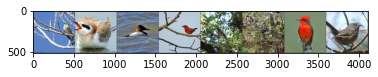

Labels:Yellow-rumped Warbler (Breeding Audubon's), Forster's Tern, Canvasback (Breeding male), Summer Tanager (Adult Male), Hutton's Vireo, Blue Grosbeak (Adult Male), Vermilion Flycatcher (Adult male),   Wrentit


In [162]:
dataiter = iter(data['train'])
images, labels = dataiter.next()
images = images[:8]
print(images.size())

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print("Labels:" + ', '.join('%9s' % data['to_name'][labels[j].item()] for j in range(8)))

#### training function: learning rate, momentum, decay all kept constant

In [4]:
def train(net, dataloader, epochs=1, start_epoch=0, lr=0.01, momentum=0.9, decay=0.0005, 
          verbose=1, print_every=10, state=None, schedule={}, checkpoint_path=None):
    net.to(device)
    net.train()
    losses = []
    # applies log-softmax
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=decay)

    # Load previous training state
    if state:
        net.load_state_dict(state['net'])
        optimizer.load_state_dict(state['optimizer'])
        start_epoch = state['epoch']
        losses = state['losses']

    # Fast forward lr schedule through already trained epochs
    for epoch in range(start_epoch):
        if epoch in schedule:
            print ("Learning rate: %f"% schedule[epoch])
            for g in optimizer.param_groups:
                g['lr'] = schedule[epoch]

    for epoch in range(start_epoch, epochs):
        sum_loss = 0.0

        # Update learning rate when scheduled
        if epoch in schedule:
            print ("Learning rate: %f"% schedule[epoch])
            for g in optimizer.param_groups:
                g['lr'] = schedule[epoch]

        for i, batch in enumerate(dataloader, 0):
            inputs, labels = batch[0].to(device), batch[1].to(device)

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()  # autograd magic, computes all the partial derivatives
            optimizer.step() # takes a step in gradient direction

            losses.append(loss.item())
            sum_loss += loss.item()

            if i % print_every == print_every-1:    # print every 10 mini-batches
                if verbose:
                  print('[%d, %5d] loss: %.3f' % (epoch, i + 1, sum_loss / print_every))
                sum_loss = 0.0
        if checkpoint_path:
            state = {'epoch': epoch+1, 'net': net.state_dict(), 'optimizer': optimizer.state_dict(), 'losses': losses}
            torch.save(state, checkpoint_path + 'checkpoint-%d.pkl'%(epoch+1))
    return losses

## Submission 1: 50.6%
##### submitted checkpoint-6

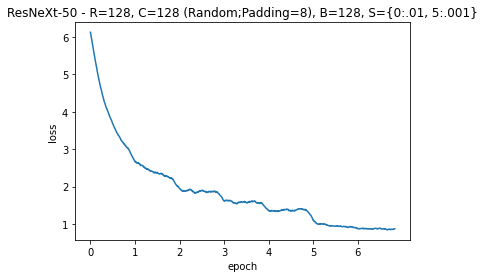

In [230]:
graph('C:/Users/hi/checkpoints/checkpoint-7.pkl', batch_size=128, title='ResNeXt-50 - R=128, C=128 (Random;Padding=8), B=128, S={0:.01, 5:.001}')

## Submission 2: 76.95%
##### submitted checkpoint-5

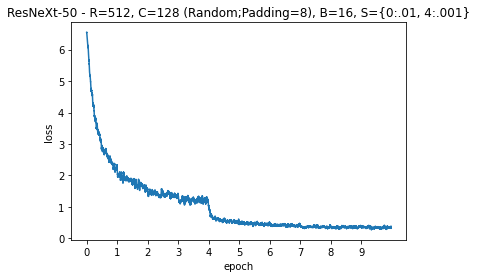

In [221]:
graph('C:/Users/hi/checkpoints-resnext50/checkpoint-10.pkl', batch_size=16, title='ResNeXt-50 - R=512, C=128 (Random;Padding=8), B=16, S={0:.01, 4:.001}')

## Submission 3 & 4: 18.4% & 15.8%
### ResNeXt-101
##### submitted checkpoint-9 & checkpoint-6
(I thought first score was so low due to overfitting)

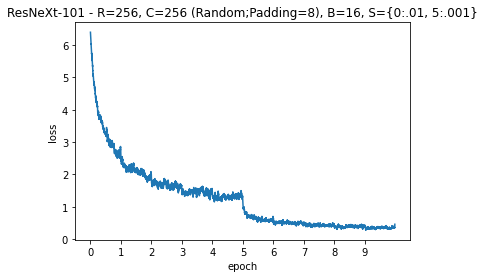

In [222]:
graph('C:/Users/hi/checkpoints-resnext101-alt/checkpoint-10.pkl', batch_size=16, title='ResNeXt-101 - R=256, C=256 (Random;Padding=8), B=16, S={0:.01, 5:.001}')

***

let's try bigger pictures even though the batch size is just 6...

(the checkpoints were deleted)

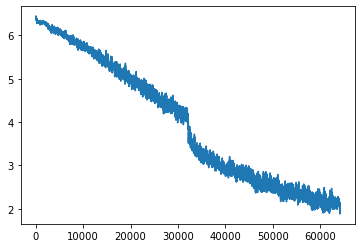

In [6]:
# ResNeXt-101 - R=512, C=512 (Random;Padding=8), B=6, S={0:.01, 5:.001}

## Submission 5: 77.05%
##### submitted checkpoint-6

(accidentally replaced with Submission 6)

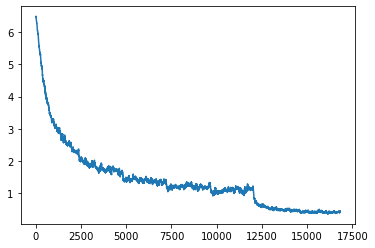

In [ ]:
# ResNeXt-50 - R=512, C=512 (Random;Padding=8), B=16, S={0:.01, 5:.001}, epochs=7

## Submission 6 & 8: 78.2% & 80.45%
##### submitted checkpoint-6 & checkpoint-10
I eventually find out here that my model doesn't have an overfitting issue that I was assuming would be present (why I was submitting lower checkpoints)

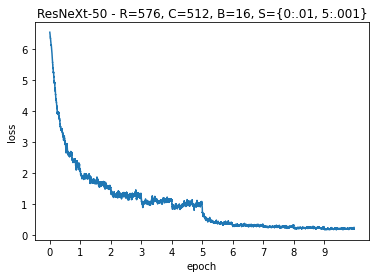

In [223]:
graph('C:/Users/hi/checkpoints-resnext50-center/checkpoint-10.pkl', batch_size=16, title='ResNeXt-50 - R=576, C=512, B=16, S={0:.01, 5:.001}')

## Submission 7: 78.7%
##### submitted checkpoint-10
loss seems to have plateaued...introducing .0001 learning rate

(it doesn't help that much)

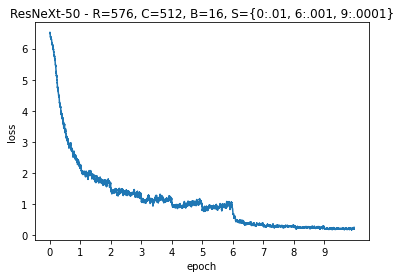

In [220]:
graph('C:/Users/hi/checkpoints-resnext50-center-10epoch/checkpoint-10.pkl', batch_size=16, title='ResNeXt-50 - R=576, C=512, B=16, S={0:.01, 6:.001, 9:.0001}')

***

0.0001 has been introduced, why not 0.1 learning rate too?

(the checkpoints were also deleted)

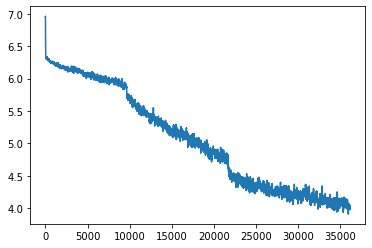

In [ ]:
# ResNeXt-50 - R=576, C=512, B=16, S={0:.1, 4:.01, 9:.001}, epochs=10

## Submission 9: 80.95%
##### submitted checkpoint-18
continued training from same model of Submission 6 & 8 (moar epoch ?= moar accuracy)

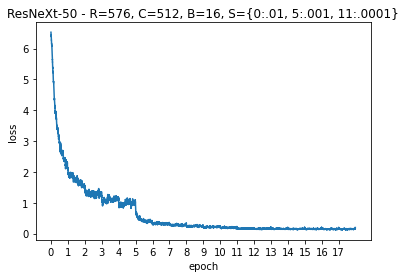

In [227]:
graph('C:/Users/hi/checkpoints-resnext50-center/continuationcheckpoint-18.pkl', batch_size=16, title='ResNeXt-50 - R=576, C=512, B=16, S={0:.01, 5:.001, 11:.0001}')

## Submission 10: 13.00%
### ResNeXt-101
##### submitted checkpoint-18
(okay ResNext-50 lookin' pretty good, how about 10- nvm just making sure it wasn't a fluke)

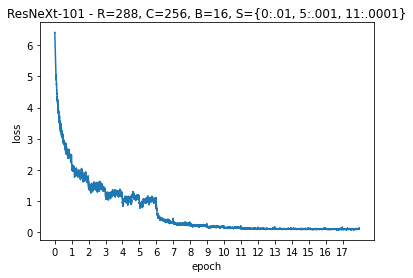

In [225]:
graph('C:/Users/hi/checkpoints-resnext101-again/checkpoint-18.pkl', batch_size=16, title='ResNeXt-101 - R=288, C=256, B=16, S={0:.01, 5:.001, 11:.0001}')

# Final Submission 11: 82.05%
#### submitted checkpoint-18

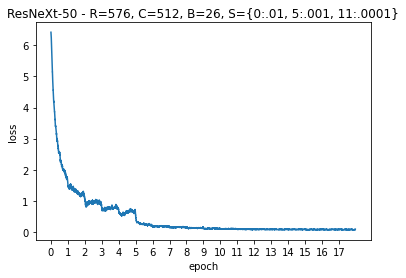

In [233]:
# had to use Colab for this one - 7 hour runtime
graph('C:/Users/hi/checkpoints-resnext50-final/checkpoint-18.pkl', batch_size=26, title='ResNeXt-50 - R=576, C=512, B=26, S={0:.01, 5:.001, 11:.0001}')

***
# A Couple More Graphs
(these are more interesting I hope)

### Top two accuracy vs. worst accuracy models

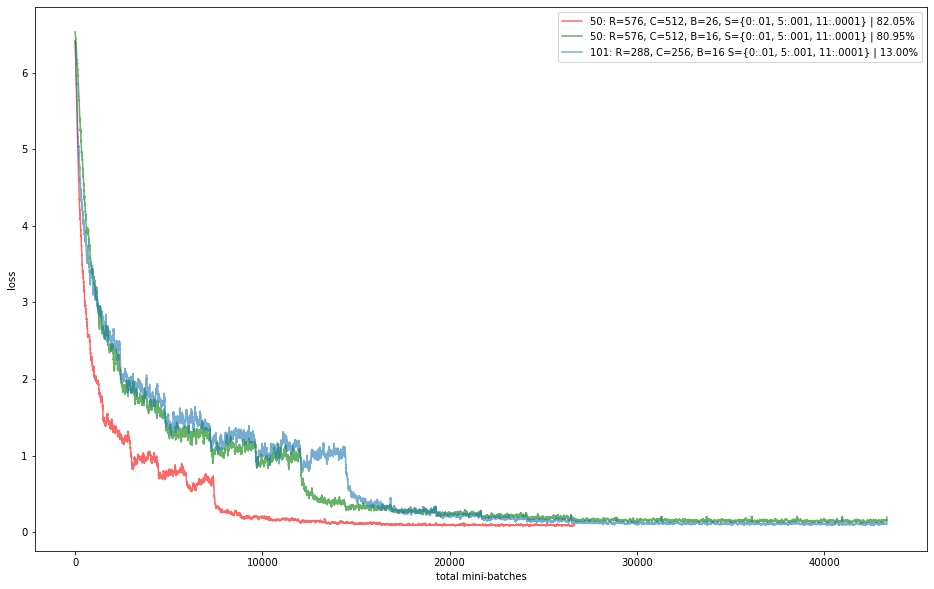

In [386]:
ckpts = ["C:/Users/hi/checkpoints-resnext50-final/checkpoint-18.pkl",
         "C:/Users/hi/checkpoints-resnext50-center/continuationcheckpoint-18.pkl", 
         "C:/Users/hi/checkpoints-resnext101-again/checkpoint-18.pkl",]
multi_graph(ckpts, 
            title='',
            colors=['-r', '-g', ''], 
            labels=['50: R=576, C=512, B=26, S={0:.01, 5:.001, 11:.0001} | 82.05%', 
                    '50: R=576, C=512, B=16, S={0:.01, 5:.001, 11:.0001} | 80.95%',
                    '101: R=288, C=256, B=16 S={0:.01, 5:.001, 11:.0001} | 13.00%',],
            alpha=0.6,
            plot_size=(19,10))

### All ResNeXt-50 Model Submissions

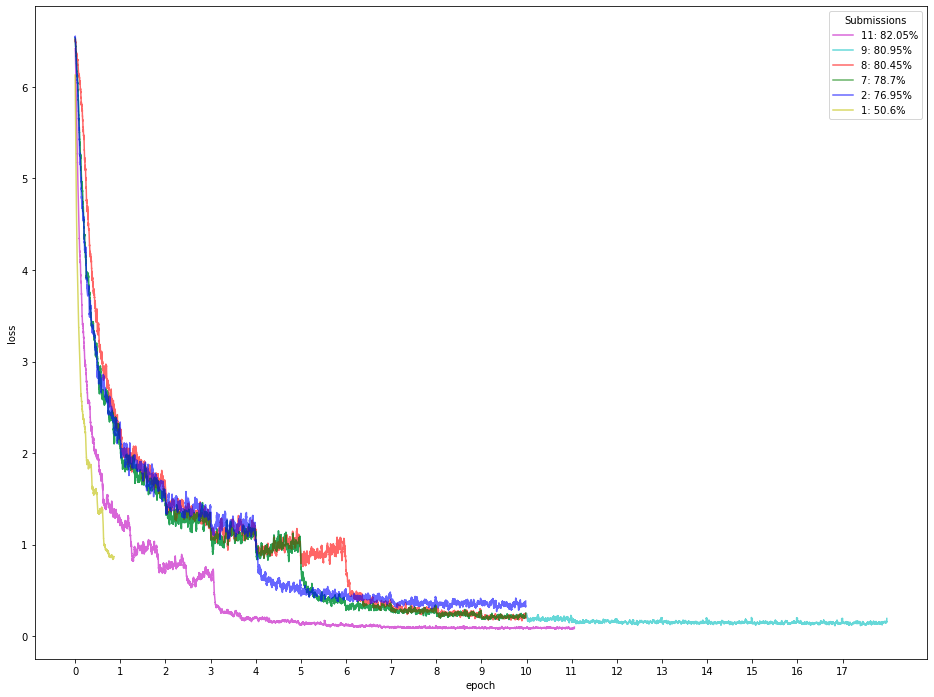

In [379]:
ckpts = ["C:/Users/hi/checkpoints/checkpoint-7.pkl",
"C:/Users/hi/checkpoints-resnext50/checkpoint-10.pkl", 
"C:/Users/hi/checkpoints-resnext50-center/checkpoint-10.pkl",
"C:/Users/hi/checkpoints-resnext50-center-10epoch/checkpoint-10.pkl",
"C:/Users/hi/checkpoints-resnext50-center/continuationcheckpoint-18.pkl",
"C:/Users/hi/checkpoints-resnext50-final/checkpoint-18.pkl",
]
ckpts.reverse()
#labels = ['ResNeXt-50 - R=128, C=128 (Random;Padding=8), B=128, S={0:.01, 5:.001}',
#'ResNeXt-50 - R=512, C=128 (Random;Padding=8), B=16, S={0:.01, 4:.001}',
#'ResNeXt-50 - R=576, C=512, B=16, S={0:.01, 5:.001}',
#'ResNeXt-50 - R=576, C=512, B=16, S={0:.01, 6:.001, 9:.0001}',
#'ResNeXt-50 - R=576, C=512, B=16, S={0:.01, 5:.001, 11:.0001}',
#'ResNeXt-50 - R=576, C=512, B=26, S={0:.01, 5:.001, 11:.0001}',
#]
labels = ['1: 50.6%', '2: 76.95%', '7: 78.7%', '8: 80.45%', '9: 80.95%', '11: 82.05%']
labels.reverse()
multi_graph(ckpts, 
            batch_size=16, # slight inaccuracies as 1 has B=128 and 11 has B=26
            title='', 
            legend_title='Submissions',
            colors=['-m', '-c', '-r', '-g', '-b', '-y'], 
            labels=labels,
            alpha=0.6,
            plot_size=(16,19))

## Graph Functions

In [288]:
def getTotalMiniBatches(batch_size):
    trainset = torchvision.datasets.ImageFolder(root='birds22sp/train') #38,562 imgs for birds
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size)
    return len(trainloader)

In [228]:
# Plots a loss function graph for bird dataset
def graph(file_path, batch_size, title='', color=''):
    state = torch.load(file_path)
    fig, ax = plt.subplots()
    y = smooth(state['losses'], 50)
    xi = range(len(smooth(state['losses'], 50)))
    plt.plot(xi, y, color)
    n = getTotalMiniBatches(batch_size)
    plt.xticks(np.arange(min(xi), max(xi)+1, n))
    
    ax.set_title(title)
    ax.set_ylabel('loss')
    ax.set_xlabel('epoch')
    ax.get_xaxis().set_major_formatter(
        tkr.FuncFormatter(lambda x, p: format(int(x/n))))
    plt.show()

In [387]:
# Plots multiple loss functions in the same graph
# Increases in z-axis (last graphed line is at the front)
def multi_graph(file_paths, batch_size=0, title='', legend_title='', colors=[], labels=[], alpha=1, plot_size=(8,5.5)):
    fig, ax = plt.subplots()
    max_xi = range(1)
    for i in range(len(file_paths)):
        state = torch.load(file_paths[i])
        y = smooth(state['losses'], 50)
        xi = range(len(smooth(state['losses'], 50)))
        if xi[-1] > max_xi[-1]:
            max_xi = xi
        plt.plot(xi, y, colors[i], label=labels[i], alpha=alpha)
    if batch_size:
        n = getTotalMiniBatches(batch_size)
        plt.xticks(np.arange(min(max_xi), max(max_xi)+1, n))
    
    ax.set_title(title)
    ax.set_ylabel('loss')
    if labels:
        ax.legend(title=legend_title)
    if batch_size: 
        ax.set_xlabel('epoch')
        ax.get_xaxis().set_major_formatter(
            tkr.FuncFormatter(lambda x, p: format(int(x/n))))
    else:
        ax.set_xlabel('total mini-batches')
    # increase plot size
    plt.rcParams["figure.figsize"] = plot_size # kinda bugs out?
    plt.show()

## Prediction (for submission)

In [10]:
def predict(net, dataloader, ofname):
    out = open(ofname, 'w')
    out.write("path,class\n")
    net.to(device)
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for i, (images, labels) in enumerate(dataloader, 0):
            if i%100 == 0:
                print(i)
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            fname, _ = dataloader.dataset.samples[i]
            out.write("{}\n".format([predicted.item()]))
    out.close()

In [14]:
# Load model from checkpoint
resnet = torch.hub.load('pytorch/vision:v0.10.0', 'resnext50_32x4d', pretrained=True)
resnet.fc = nn.Linear(2048, 555)
state = torch.load('C:/Users/hi/checkpoints-resnext50-final/checkpoint-18.pkl')
resnet.load_state_dict(state['net'])

predict(resnet, data['test'], 'C:/Users/hi/checkpoints-resnext50-final/checkpoint-18.csv')

Using cache found in C:\Users\hi/.cache\torch\hub\pytorch_vision_v0.10.0


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
